# **Style Transfer**

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

### **La idea de este trabajo final es reproducir el siguiente paper:**

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

**_En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma._**

**_Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes._**


# Se Cargan las imágenes
Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [ ]:
# Imagen para estilo
!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# Creamos el directorio para los archivos de salida
!mkdir /content/output

--2021-12-20 11:55:52--  https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223725 (218K) [image/jpeg]
Saving to: ‘La_noche_estrellada1.jpg.1’

La_noche_estrellada 100%[===================>] 218.48K  1.28MB/s    in 0.2s    

2021-12-20 11:55:53 (1.28 MB/s) - ‘La_noche_estrellada1.jpg.1’ saved [223725/223725]

--2021-12-20 11:55:53--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1530

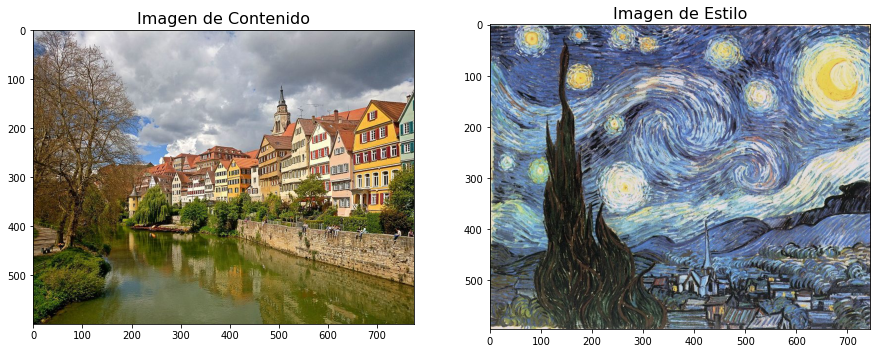

In [ ]:
from PIL import Image   
from matplotlib import pyplot as plt

# Abrir Imágenes
Content = Image.open('775px-Neckarfront_Tübingen_Mai_2017.jpg') 
Style = Image.open('La_noche_estrellada1.jpg')

# Mostrar Imágenes
plt.figure(figsize=(15,15)) 
plt.subplot(1, 2, 1)
plt.title("Imagen de Contenido", fontsize="16")
plt.imshow(Content)
plt.subplot(1, 2, 2)
plt.title("Imagen de Estilo", fontsize="16")
plt.imshow(Style)

In [ ]:
%tensorflow_version 1.x
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

base_image_path = Path("/content/775px-Neckarfront_Tübingen_Mai_2017.jpg")
style_reference_image_path = Path("/content/La_noche_estrellada1.jpg")
result_prefix = Path("/content/output")
iterations = 100

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

## **MB Respuesta 1:**


Significan los pesos otorgados a contenido y al estilo en nuestra función de costo total de variación. Ellos, consituyen un elemento fundamental del modelo pues, a través de los mismos, podrá darse  énfasis en hacer concidir el contenido o el estilo de la imagen.
La pérdida total, se puede escribir como una suma ponderada de las perdidas de estilo y contenido. Si bien existen diferentes hiperárámetros que requieren ajuste manual, el más importante es el peso relativo entre la pérdida de contenido y la pérdida del estilo. Lo expuesto ocurre ya que  el peso de la función de costo total de variación, impactará sobre cuan ruidosa es la imagen generada como output.

El chart que se incluye a continuación, representa claramente cómo funciona la CNN para la transferencia de estilo neuronal:

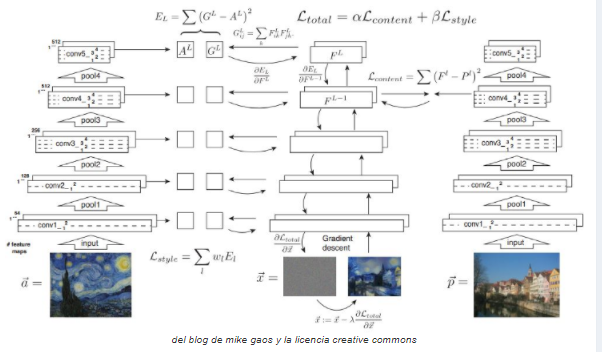


### **_Definiciónes:_**

**Style_weight** ($\beta$): Este hiperparámetro otorga un determinado peso al estilo de la imagen. Para definir el concepto, debemos referirnos a la Función de Pérdida de Reconstrucción de Estilo (Style Recostreuction Loss).
La representación del estilo, se construye calculando las correlaciones entre los diferentes filtros de respuesta. La pérdida total  es la suma ponderada de la Pérdida de Reconstrucción de Estilo de cada capa de la red neuronal.

En esencia, para descubrir el estilo de una imagen, e identificar sus texturas, patrones y colores:

1. Se procesa la imagen de estilo analizando sus píxeles
2. Se alimenta esta información a la capa de un modelo previamente entrenado para "entender" / clasificar la entrada proporcionada.


Ecuación 1

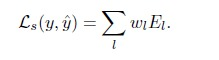


Un fuerte énfasis en el hiperparámetro Beta (estilo) generará una  mayor coincidencia  con el estilo de la imagen original.


**Content_weight** ($\alpha$): Este parámetro otorga un determinado peso del contenido de la imagen. Para definir el concepto, debemos referirnos a la Función de Pérdida de Reconstrucción de Contenido (Content Reconstreuction Loss).

Ecuación 2

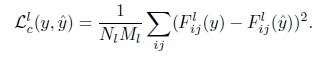

La propiedad de la Función de Pérdida de Reconstrucción de Contenido es que fomenta la generación de imágenes a fin de obtener  representaciones de características similares en lugar de obligarlas a coincidir píxel por píxel.

A mayor ponderación de Alpha, mayor será la indetificación de la imágen de salida con el contenido de la imagen original.

En consecuencia, para generar las imágenes que refleajan conjuntamente contenido y estilo, combinamos las ecuaciones 1 y 2 para consutruir una ecuación de pérdida conjunta (Total Variation Loss). 

**Total_Variation_Weight** ($\gamma$): Este peso es un parámetro relativo a la  Total Variation Loss, el cual suaviza las diferencias entre estilo y contenido entre la imagen original y producida como resultado de nuestro modelo.

En el ejemplo brindado, ( $\alpha$= 1, $\beta$ = 10, $\gamma$= 0.1 ) se otorga una mayor poderación en el estilo en comparación al contenido, el cual se suaviza levemente regularizando el modelo a través de la total variation loss.




In [ ]:
# Definimos el énfasis que tendrá la imagen
total_variation_weight = 0.1
style_weight = 10
content_weight = 1

In [ ]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [ ]:
# Content image
print(width, height) # Tamaño original

# Style image
width1, height1 = load_img(style_reference_image_path).size
print(width1, height1) #Tamaño original

# Nuevo tamaño de las imagenes de contenido, estilo y salida
print(img_ncols,img_nrows) 

775 599
745 596
517 400


# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

## **MB Respuesta 2:**

Línea np.expand_dims: Esta función expande el array insertando un nuevo eje en la posición especificada. La misma, requiere dos parámetros. En este caso particular se modifica de (400, 517, 3) a (1, 400, 517, 3).

Línea vgg19.preprocess_input:  devuelve las imágenes convertidas de RGB a BGR (en este caso, el formato requerido por la vgg19). Luego, cada canal de color está centrado en cero con respecto al conjunto de datos ImageNet sin escala.

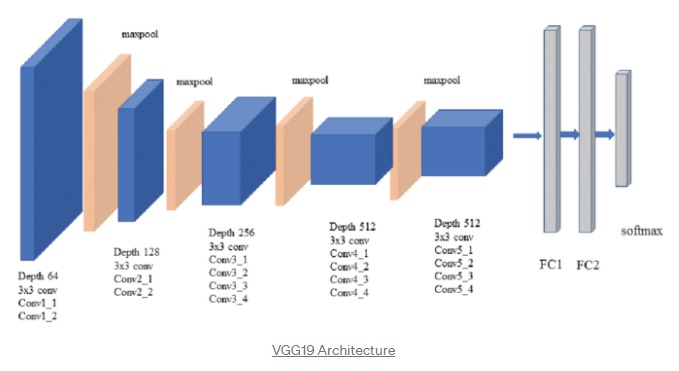

En lo que respecta a las primeras líneas de código de la función, se procede a definir la ubicación de la imagen para luego cargar la misma, se determina su ancho y alto y se la transforma en numpy array (bit: 0-255).


 

In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

## **MB Respuesta 3:**

La celda da nueva forma al array sin cambiar sus datos, es decir, que el array adopta el formato original:

1. (400, 517, 3)
2. Se convierte la imagen de BGR a RGB.
3. Se normalizan los píxels (0-255).




In [ ]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [ ]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [ ]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


80142336/80134624 [==============================] - 8s 0us/step
Model loaded.


# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?
- ¿Por qué se permutan las dimensiones de x?

## **Marian Respuesta 4:**

**¿Qué es la matriz de Gram?**

La Matrix Gram es una matriz de productos internos entre k vectores. Puede verse como una matriz de covarianza entre características, sin restar la media. Si la diferencia en la matriz de Gram de los vectores de características de las dos imágenes es pequeña, podemos establecer que las dos imágenes son similares en la transferencia de estilo. Lo que realiza la Gram es calcular la correlación entre dos características, cuáles dos características aparecen al mismo tiempo, cuáles son las opuestas, etc. Asimismo, los elementos de la diagonal reflejan la cantidad de características que aparecen en la imagen.


**¿Para qué se usa?**

La matriz de Gram se utiliza para codificar la correlación entre diferentes características en lugar de identificar  la presencia de características específicas. De este modo, Gram permite minimizar la diferencia entre las distribuciones de características.

Se aplica en la función de pérdida de estilo, es decir,  para calcular la diferencia normalizada al cuadrado en matrices de Gram entre las dos imágenes. En otras palabras, la diferencia entre la imagen original y la generada lo cual constituye la transferencia de estilo.

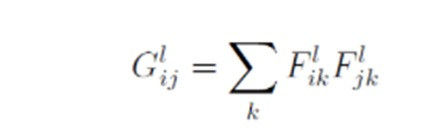

En la ecuación anterior, Gˡᵢⱼ es el producto interno entre el mapa de características vectorizado i y j en la capa l. La ecuación vectorizada de una matriz de gram se muestra en la siguiente figura:

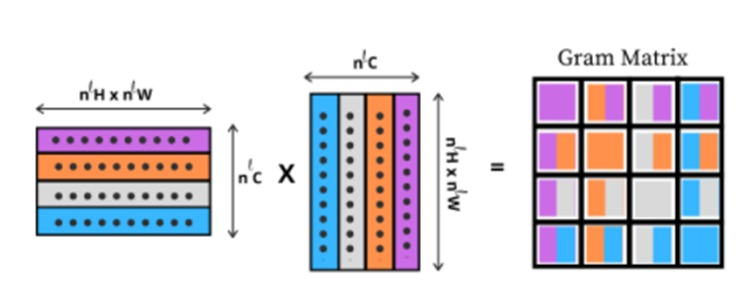

**¿Por qué se permutan las dimensiones de x?**

Ello ocurre ya que la Matriz Gram está definida como $G=FF^T$. 





In [ ]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:

# Explicar qué mide cada una de las losses en las siguientes tres celdas.

## **MB Respuesta 5:**

Para definir las looses, me referiré al paper de Stanford University "Real-time Image Style Transfer", de Sophia Lu, Zhaoyou Wang y Zhaoheng Guo, quienes llevaron a cabo un análisis sobre la resolución del problema de style transfer a partir de la evaluación de métodos alternativos. El problema de transferencia de estilo lo han planteado del siguiente modo: 

Dada una imagen de contenido yc de estilo ys, ¿Cómo podemos encontrar una nueva imagen y que está cerca de yc en contenido y de ys en estilo? El punto clave para resolver este problema matemáticamente definir la distancia o diferencia de contenido entre dos imágenes, así como la distancia de estilo entre dos imágenes. En esta línea de pensamiento, el costo constituye la  diferencia entre la imagen original y la generada. Por lo tanto, al reducir las dos distancias juntas, generamos una solución  que es la imagen estilizada. He allí donde refieren a los siguientes conceptos: "Content Reconstruction Loss", "Style Reconstruction Loss" y "Total variation loss", los cuales se definen a continuación:


**Content Reconstruction Loss**: El contenido de una imagen, está definido como los objetos que el ser humano puede reconocer. Tal como es mencionado en el paper paper "A Neural Algorithm of Artistic Style" por L. Gatys, A. Ecker y M. Bethge: Las capas superiores de la red capturan el contenido de alto nivel en términos de objetos y sus disposición en la imagen de entrada, pero no se restringen los valores de píxeles exactos de la reconstrucción.  Por el contrario, las reconstrucciones de las capas inferiores reproducen los valores de píxel exactos de la imagen original. En consecuencia, es en las   capas superiores de la red  donde se define el contenido de representación. 
Por lo expuesto, ante dos imágenes que tienen el mismo contenido, deberían producirse activaciones similares en las capas superiores. De este modo, la pérdida de contenido puede definirse como el error cuadrático entre la imagen de salida y la representación de contenido de la imagen original.

Para definir la función de pérdida de contenido supongamos  que en la capa l tenemos Nl filtros distintos y Ml es el longitud total de la “feature response”.  La respuesta en la capa l se puede representar en una matriz: 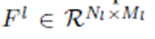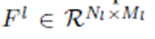 donde 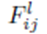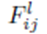 es la activación del i-ésimo filtro en la posición j en el capa l. Si tenemos una imagen de entrada "y" y una imagen generada "^y", las respectivas representaciones de características de ellos son . Entonces la pérdida de reconstrucción de contenido en la l-ésima capa se define como:

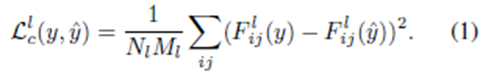
 
La definición de la ecuación fomenta la representacións de características similares, en lugar de obligarlos a hacer coincidir cada uno de los píxels.


**Style Reconstruction Loss**: La definición del estilo de una imagen está dado por la capacidad de indentificar características en ella presentes como ser  texturas y colores. 
La pérdida de estilo es el error cuadrático entre la representación de estilo de la imagen de salida y el estilo de la  imagen original.

El costo total del estilo se calcula en dos pasos:

1ro: Consiste en calcular el costo de estilo de todas las capas convolucionales y comparar los vectores  de características entre las capas (encontrar su correlación).

2do: Calcular el costo de estilo entre el imagen original y la imagen generada.

En términos matemáticos, sintentizando lo expuesto, la representación del estilo se construye calculando las correlaciones entre las diferentes “filter responses”. Las correlaciones de características están dadas por la matriz de Gram 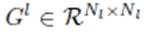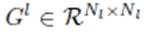  donde se calcula   como la correlación entre las "feature responses" 

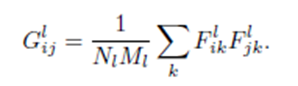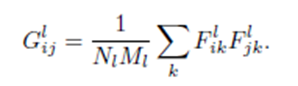

Donde el factor de normalización proviene de promediar sobre diferentes filtros y el largo de las “filter responses”. Si tenemos una imagen de entrada ![image.png](attachment:cb4![image.png](attachment:60bf6e69-4dee-4ed3-844e-e7f8e40cf6d2.png), 7a0e-2f90-4a23-aa84-ac112516e351.png)  una imagen generada , las respectivas matrices de Gram de ellos son 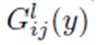 y 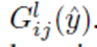. 
Entonces la pérdida de reconstrucción de estilo en el l-ésima  capa se define como:

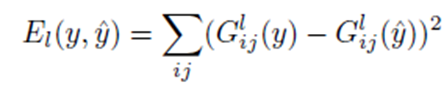


**Total variation loss**: La función de pérdida de variación total tiene por objeto regularizar la imagen generada, es decir, mejorar su suavidad entre estilo y contenido,  a fin de obtener un mejor resultado. En esencia, suavizamos las diferencias entre estilo y transferencia de contenido dentro de la imagen generada.

En términos matemáticos, para generar las imágenes que mezclen el contenido y el estilo, combinamos la función de pérdida de contenido y de estilo, es decir:


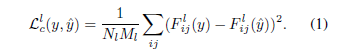; 

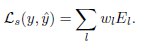

y de este modo contruimos la función de pérdida conjunta. Sean yc e ys las imágenes que aportan el contenido y el estilo:



El output La imagen generada, es decir el output, ^y, surge de optimizar esta última ecuación siendo el mismo:

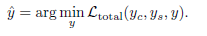




In [ ]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [ ]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [ ]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [ ]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [ ]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función **_fmin_l_bfgs_b_**? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

* ## **MB Respuesta 6:**

**Propósito de las celdas:**

Se utiliza la función def eval_loss_and_grads(x). Se introduce un Evaluador que devuelve la pérdida y el gradiente en dos funciones separadas, pero los cálculos de las dos variables son dependientes. Esto reduce el tiempo de cálculo, ya que de lo contrario se calcularía por separado. En otras palabras,  hace posible el cálculo de la pérdida y los gradientes en un paso pues calcular la pérdida y el gradiente en forma separada sería ineficiente. Luego se efectúan una serie de iteraciones, minimizando la loss y optimizando el modelo.


**¿Qué hace la función **fmin_l_bfgs_b?**

La función fmin_l_bfgs_b utiliza los valores calcualdos por el evaluador (losses) y los minimiza para obtener la "optimal loss" de la imagen generada. 

Ello, requiere comprender el algoritmo L-BFGS_B, el cual es un algoritmo de memoria limitada para resolver grandes problemas de optimización no lineal sujetos a límites simples en las variables. Está pensado para problemas en los que es difícil obtener información sobre la matriz Hessiana, o para problemas grandes y densos.  L-BFGS-B  permite la incorporación de restricciones de "boxed constraints", es decir, restricciones simples de la forma ai≤θi≤bi para cualquiera o todos los parámetros θi.

Dado que el  algoritmo L-BFGS_B requiere cálculos separados para las Loss y los gradientes, se utiliza el Evaluador con el objeto de eficientizar el modelo, tal como ha sido explicado en la pregunta precedente. Las losses resultantes son utilizadas por la función fmin_l_bfgs_b.

**¿En qué se diferencia con la implementación del paper?**

Los análsis efectuados en torno al paper "A Neural Algorithm of Artistic Style" refieren al optimzador  L-BFGS, mientras que en este caso nuestro modelo utilizó L-BFGS-B. 

 L-BFGS, desarrollado por Jorge Nocedal es capaz de resolver funciones sin restricciones, mientras que la variante L-BFGS-B (Jorge Nocedal y Richard Byrd) puede resolver funciones con restricciones simples, también denominadas  "box constraints" (ai≤θi≤bi para cualquiera o todos los parámetros θi). 

Por otra parte, en el paper se utiliza avergare pooling, el cual devuelve el promedio de todos los valores de la parte de la imagen cubierta por el Kernel mientras que, en nuestro ejercicio, no se utiliza dicha operación de cálculo, sino que la salida del modelo resulta en un tensor 4D del último bloque convolucional.

Otro aspecto que varía con respecto al paper es la función de costo total: nuestro ejercicio aplica la variation loss, mietras que el paper no emplea la misma. 

**¿Se puede utilizar alguna alternativa?**

Otra alternativa que se puede utilizar es el optimizador Adam, el cual calcula las tasas de aprendizaje adaptativo individuales para diferentes parámetros a partir de estimaciones del primer y segundo momento de los gradientes. EL mismo, constituye una combinación de las ventajas de otras dos extensiones de gradient descent, AdaGrad y RMSProp.




In [ ]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [ ]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [ ]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 13278365000.0
Image saved as /content/output/output_at_iteration_0.png
Iteration 0 completed in 22s
Start of iteration 1
Current loss value: 6507943000.0
Image saved as /content/output/output_at_iteration_1.png
Iteration 1 completed in 15s
Start of iteration 2
Current loss value: 4392987600.0
Image saved as /content/output/output_at_iteration_2.png
Iteration 2 completed in 15s
Start of iteration 3
Current loss value: 3320891600.0
Image saved as /content/output/output_at_iteration_3.png
Iteration 3 completed in 15s
Start of iteration 4
Current loss value: 2680132000.0
Image saved as /content/output/output_at_iteration_4.png
Iteration 4 completed in 15s
Start of iteration 5
Current loss value: 2302199000.0
Image saved as /content/output/output_at_iteration_5.png
Iteration 5 completed in 15s
Start of iteration 6
Current loss value: 2069208600.0
Image saved as /content/output/output_at_iteration_6.png
Iteration 6 completed in 15s
Start of iteration 

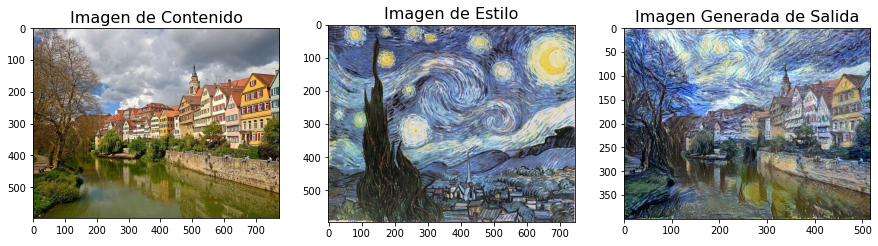

In [ ]:
# Abrir Imágenes 
Content = Image.open('775px-Neckarfront_Tübingen_Mai_2017.jpg') 
Style = Image.open('La_noche_estrellada1.jpg')
Salida = Image.open('1.png')

# Mostrar Imágenes
plt.figure(figsize=(15,15)) 
plt.subplot(1, 3, 1)
plt.title("Imagen de Contenido", fontsize="16")
plt.imshow(Content)
plt.subplot(1, 3, 2)
plt.title("Imagen de Estilo", fontsize="16")
plt.imshow(Style)
plt.subplot(1, 3, 3)
plt.title("Imagen Generada de Salida", fontsize="16")
plt.imshow(Salida)

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. 

## Adjuntar las imágenes generadas como archivos separados.

## **MB Respuesta 8:**




* $Imagenes$ $1$ y $2:$

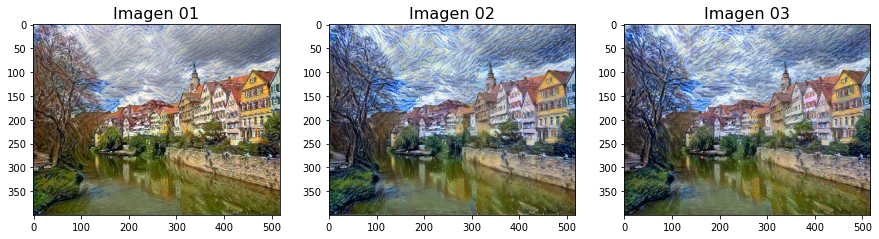

In [1]:
from PIL import Image   
from matplotlib import pyplot as plt

# Abrir Imágenes 
I1 = Image.open('IMAGENES/Imagen 1.png') 
I2 = Image.open('IMAGENES/Imagen 2.png')
I3 = Image.open('IMAGENES/Imagen 3.png')

# Mostrar Imágenes
plt.figure(figsize=(15,5)) 
plt.subplot(1, 3, 1)
plt.title("Imagen 01", fontsize="16")
plt.imshow(I1)
plt.subplot(1, 3, 2)
plt.title("Imagen 02", fontsize="16")
plt.imshow(I2)
plt.subplot(1, 3, 3)
plt.title("Imagen 03", fontsize="16")
plt.imshow(I3)


** MB modificación de pesos para las imágenes generadas**

**_Las imágenes 1, 2 y 3 fueron entrenadas con los siguientes pesos:_**

Imagen 1:
iterations = 1
total_variation_weight = 0.1
style_weight = 10
content_weight = 1


Imagen 2:
iterations = 10
total_variation_weight = 0.2
style_weight = 15
content_weight = 5

Imagen 3:
iterations = 15
total_variation_weight = 0.4
style_weight = 8
content_weight = 50



**Comentarios MB sobre las variaciones de pesos en las imágenes generadas**

En la imagen 1 se mantuvieron los pesos inciales, mientras que en las imagenes 2 y 3 modifiqué los pesos para evaluar diferentes ponderaciones hacia el estilo o el contenido.

Imagen 2: Incrementé el número de iteraciones y enfaticé en el estilo al incrementar su peso.

Imagen 3: Ponderé el contenido por sobre el estilo.

Se puede observar especialmente en el cielo imágenes y en lo objetos de las mismas (ej. casa) el impacto de dichas modificaciones. Asimismo, modifiqué el número de iteraciones a fin de evaluar su impacto en las imágenes generadas hasta lograr la estética del output deseado.

# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

** MB Respuesta 9**:

In [ ]:
**SELECCIÓN DE LAS IMAGENES: IMAGEN 1**
    
La primera imagen de contendio que seleccioné es la tapa del album incónico de Los Beatles "Abbey Road".
El mismo fue lananzado en Septiembre de 1969, siendo el último disco grabado por la banda.

Para definir el estilo, opté por  un artista contemporáneo, de la década del 60, Andy Warhol, y a su ora distintiva
Marilyn Diptych, del año 1962.

Cosnideré sumamente interesante y simbólico combinar el contenido de una banda de gran inlfuencia global y cultural,
como Los Beatles, con un referente que llevó a cabo un rol trascendental para el naciomiento del pop art, Andy Warhol, 
caracterizado justamente por representar el consumo de masas y contenido publicitario de la época.

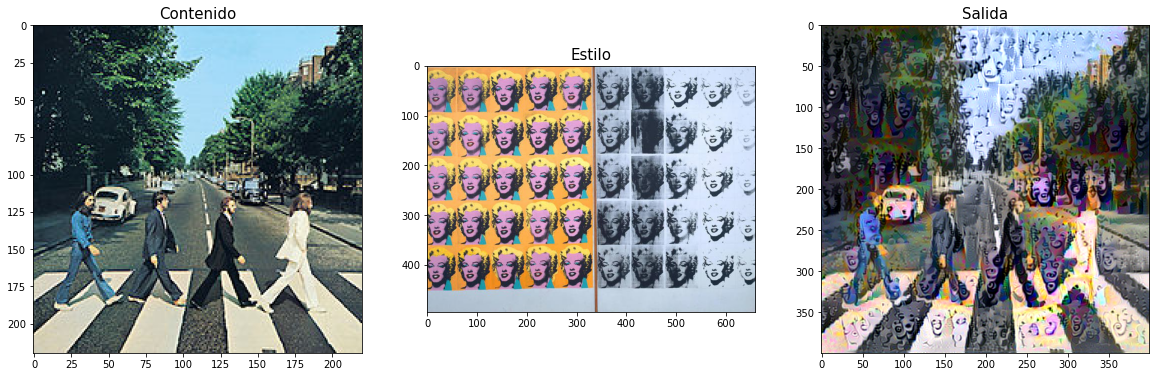

In [4]:
from PIL import Image   
from matplotlib import pyplot as plt

# Abrir Imágenes 
I1 = Image.open('IMAGENES/Content 1.jpg') 
I2 = Image.open('IMAGENES/Style 1.jpg')
I3 = Image.open('IMAGENES/Beatles.png')

# Mostrar Imágenes
plt.figure(figsize=(20,15)) 
plt.subplot(1, 3, 1)
plt.title("Contenido", fontsize="15")
plt.imshow(I1)
plt.subplot(1, 3, 2)
plt.title("Estilo", fontsize="15")
plt.imshow(I2)
plt.subplot(1, 3, 3)
plt.title("Salida", fontsize="15")
plt.imshow(I3)

In [ ]:
Para el la transferencia  contenido y estilo, busqué balancear ambas dimensiones, a través de la 
definiciónde Alpha y Beta, a fin de lograr un equilibrio en las mismas.
A medida que incrementé el número de iteraciones fui observndo la acentuación la acentuación de colores, manifestádose en mayor intensidad la paleta de violetas y amarillos. 

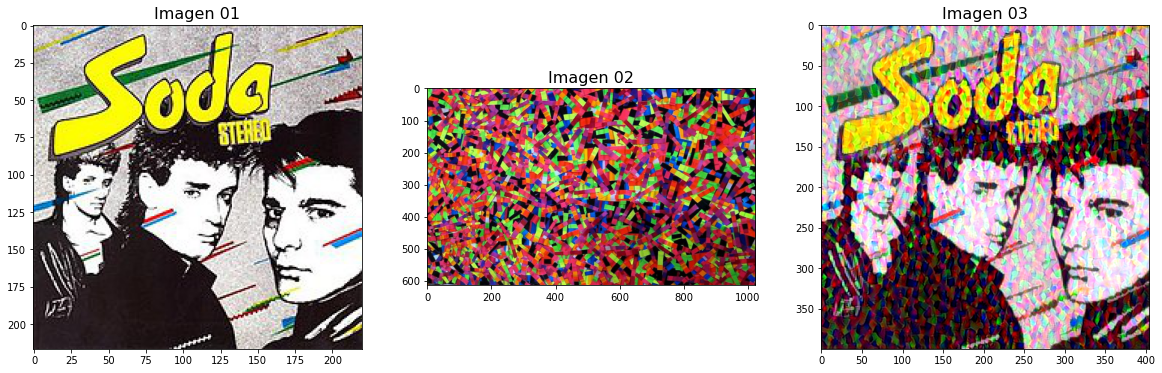

In [6]:
from PIL import Image   
from matplotlib import pyplot as plt

# Abrir Imágenes 
I1 = Image.open('IMAGENES/Content 2.jpg') 
I2 = Image.open('IMAGENES/Style 2.jpg')
I3 = Image.open('IMAGENES/Soda.png')

# Mostrar Imágenes
plt.figure(figsize=(20,15)) 
plt.subplot(1, 3, 1)
plt.title("Imagen 01", fontsize="16")
plt.imshow(I1)
plt.subplot(1, 3, 2)
plt.title("Imagen 02", fontsize="16")
plt.imshow(I2)
plt.subplot(1, 3, 3)
plt.title("Imagen 03", fontsize="16")
plt.imshow(I3)

In [ ]:
En lo que respecta a la elección de la 2da imagen, para el contenido, opté por una destacada banda argentina, Soda Stereo,
y la artista Marta Minujín, nacida en Buenos Aires. En este caso, en la definición de los hiperparámetros, ponderé Beta, es decir, el estilo sobre el contenido, lo cual queda claramente reflejada en la imagen generada. 

# **MB Bibliografía Consultada:**

Papers:

"Real-time Image Style Transfer". Stanford University. Zhaoyou Wang, Zhaoheng Guo, Sophia Lu.
http://cs229.stanford.edu/proj2017/final-reports/5244259.pdf

"Deep Learning for Text Style Transfer: A Survey" (2022) Massachusetts Institute of Technology (MIT) Article Repository.  Di Jin, Zhijing Jin, Zhiting Hu, Olga Vechtomova, Rada Mihalcea.
https://direct.mit.edu/coli/article/doi/10.1162/coli_a_00426/108845/Deep-Learning-for-Text-Style-Transfer-A-Survey

"Understanding Decisions and Tradeoffs of Neural Style Transfer" (2021). Harvard University. Morgan, Nick.
https://dash.harvard.edu/handle/1/37367685

"A Neural Algorithm of Artistic Style". Leon A. Gatys, Alexander S. Ecker, Matthias Bethge
https://arxiv.org/abs/1508.06576

"Tutorial de Transferência de Estilo Artístico como Ferramenta Didática de Introdução ao Deep Learning na Disciplina de Introdução ao Processamento de Imagens". Filipe Schulz dos Santos.
file:///C:/Users/yd1607/Downloads/2018_FilipeSchulzDosSantos_tcc.pdf

Websites:

https://github.com/Createdd/Writing/blob/master/2020/articles/understandingCNN.md#content-cost

https://medium.com/data-science-group-iitr/artistic-style-transfer-with-convolutional-neural-network-7ce2476039fd

https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-neural-style-transfer-ef88e46697ee








